In [1]:
# ENGLISH TO HINDI TRANSLATOR USING A PRIVATE AZURE SERVICE
import os, requests, json

subscription_key = '1352efe917df4167b7e990696200e04a'
endpoint =  'https://api.cognitive.microsofttranslator.com/'

path = '/translate?api-version=3.0'
params = '&from=en&to=hi'
constructed_url = endpoint + path + params

headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Content-type': 'application/json',
    'Ocp-Apim-Subscription-Region': 'centralindia',
}

def translate(text):
    body = []
    count = 0
    if isinstance(text, list):
        for sent in text:
            body.append({'text': sent})
            count += len(sent)
            if count>10000:
                body.pop(-1)
                break
    else:
        body.append({'text': text})
    
    request = requests.post(constructed_url, headers=headers, json=body)
    response = request.json()
    
    if isinstance(text, list):
        try:
            return [result['translations'][0]['text'] for result in response]
        except:
            print(json.dumps(response,indent=2))
            print(body)
    else:
        return response[0]['translations'][0]['text']

translate('test')

'परीक्षा'

In [266]:
# TESTER FUNCTION FOR TRANSLATOR THAT COPIES TO CLIPBOARD
import pyperclip
result = translate(input())
print(result)
pyperclip.copy(result)

test
परीक्षा


In [32]:
# READING ENGLISH DATASET
import pandas as pd
df = pd.read_json('./intent.json')
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, Hello human, Hola human]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is <HUMAN>, This is <HUMAN>, I am <HU...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you?, Hello, how a...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Good thanks! My user is <HUMAN>, Good thanks!...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [33]:
# INTENTS NEED TO BE SPLIT INTO SEPARATE WORDS TO BE PROPERLY TRANSLATED
import re
def camel_case_split(str):
    return ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str))

In [34]:
# SPLIT INTENTS AND TRANSLATE TO HINDI
df['intent'] = df['intent'].apply(camel_case_split)
df['intent'] = df['intent'].apply(translate)
df.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, Hello human, Hola human]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[My user is <HUMAN>, This is <HUMAN>, I am <HU...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you?, Hello, how a...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[Good thanks! My user is <HUMAN>, Good thanks!...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [35]:
# NOW ALSO TRANSLATE TEXT AND RESPONSES
df['responses'] = df['responses'].apply(translate)
df['text'] = df['text'].apply(translate)
df.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[नमस्ते, आपको नमस्कार, हैलो, नमस्कार, आपको नमस...","[हाय मानव, नमस्ते मानव, होला मानव]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[मेरा उपयोगकर्ता है<HUMAN>, यह है<HUMAN>, मैं ...",[शानदार! हाय <HUMAN>! मैं कैसे मदद कर सकता हूं...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[तुम कैसे हो?, नमस्ते क्या हालचाल है?, नमस्कार...","[नमस्ते, मैं महान हूं, तुम कैसे हो?, नमस्कार क...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[अच्छा धन्यवाद! मेरा उपयोगकर्ता है<HUMAN>, अच्...",[शानदार! हाय <HUMAN>! मैं कैसे मदद कर सकता हूं...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[मेरा नाम क्या है?, आप मुझे क्या कहते हैं?, आप...",[आप <HUMAN> रहे हैं! मैं कैसे मदद कर सकता हूं?...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [44]:
# SAVE FINAL HINDI DATASET
df.to_json(f'hindi_intent.json')

In [73]:
# READ HINDI DATASET
hdf = pd.read_json('hindi_intent.json')
hdf.head()

,intent,text,responses,extension,context,entityType,entities
0,शुभकामना,"[नमस्ते, आपको नमस्कार, हैलो, नमस्कार, आपको नमस...","[हाय मानव, नमस्ते मानव, होला मानव]","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,ग्रीटिंग रिस्पांस,"[मेरा उपयोगकर्ता है<HUMAN>, यह है<HUMAN>, मैं ...",[शानदार! हाय <HUMAN>! मैं कैसे मदद कर सकता हूं...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,सौजन्य अभिवादन,"[तुम कैसे हो?, नमस्ते क्या हालचाल है?, नमस्कार...","[नमस्ते, मैं महान हूं, तुम कैसे हो?, नमस्कार क...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,सौजन्य ग्रीटिंग रिस्पांस,"[अच्छा धन्यवाद! मेरा उपयोगकर्ता है<HUMAN>, अच्...",[शानदार! हाय <HUMAN>! मैं कैसे मदद कर सकता हूं...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,वर्तमान मानव क्वेरी,"[मेरा नाम क्या है?, आप मुझे क्या कहते हैं?, आप...",[आप <HUMAN> रहे हैं! मैं कैसे मदद कर सकता हूं?...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [74]:
# SEPARATE CLUBBED TEXT ROWS
intent = []
for field in hdf.values:
    for text in field[1]:
        intent.append({'intent':field[0], 'caption':text})
data = pd.DataFrame(intent)
data.head()

In [47]:
# GET EMBEDDING OF SENTENCES
# inltk prints empty lines while encoding sentences so %%capture anulls that
%%capture
from inltk.inltk import get_sentence_encoding
X = []
for sent in data['caption']:
    X.append(get_sentence_encoding(sent,'hi'))

In [48]:
import numpy as np
X = np.array(X)
X.shape

(143, 400)

In [49]:
# ONE HOT ENCODE LABELS FOR USE IN MODEL
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
le = LabelEncoder()
intents = le.fit_transform(data['intent'])
intents = intents.reshape(-1,1)
intents = ohe.fit_transform(intents).toarray()
intents.shape

(143, 22)

In [50]:
# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, intents, test_size = 0.15)
train_X = train_X.reshape(len(train_X), 1, train_X.shape[1])
test_X = test_X.reshape(len(test_X), 1, test_X.shape[1])
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(121, 1, 400) (121, 22)
(22, 1, 400) (22, 22)


In [65]:
# BUILD MODEL
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Dropout
model = Sequential()
model.add(Bidirectional(LSTM(256), input_shape=(train_X.shape[1:])))
model.add(Dropout(0.8))
model.add(Dense(intents.shape[1], activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 512)               1345536   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 22)                11286     
Total params: 1,356,822
Trainable params: 1,356,822
Non-trainable params: 0
_________________________________________________________________


In [66]:
# TRAIN MODEL
from keras.callbacks import EarlyStopping 
from keras.callbacks import ModelCheckpoint
filepath = "weights.best.hdf5"
cp_callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es_callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_X, train_Y,
                    epochs=100, 
                    validation_data=(test_X, test_Y), 
                    batch_size=11,
                    callbacks=[es_callback,cp_callback])

Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 3.0595 - accuracy: 0.0808
Epoch 00001: val_accuracy improved from -inf to 0.27273, saving model to weights.best.hdf5
11/11 [==============================] - 2s 183ms/step - loss: 3.0507 - accuracy: 0.0909 - val_loss: 2.9561 - val_accuracy: 0.2727
Epoch 2/100
 8/11 [====================>.........] - ETA: 0s - loss: 2.8480 - accuracy: 0.3068
Epoch 00002: val_accuracy improved from 0.27273 to 0.40909, saving model to weights.best.hdf5
11/11 [==============================] - 0s 23ms/step - loss: 2.8266 - accuracy: 0.3388 - val_loss: 2.8225 - val_accuracy: 0.4091
Epoch 3/100
 7/11 [==================>...........] - ETA: 0s - loss: 2.6964 - accuracy: 0.4026
Epoch 00003: val_accuracy did not improve from 0.40909
11/11 [==============================] - 0s 15ms/step - loss: 2.6347 - accuracy: 0.4380 - val_loss: 2.6722 - val_accuracy: 0.3636
Epoch 4/100
 8/11 [====================>.........] - ETA: 0s - loss: 2.4450 - accura

 9/11 [=======================>......] - ETA: 0s - loss: 0.1916 - accuracy: 0.9596
Epoch 00029: val_accuracy did not improve from 0.72727
11/11 [==============================] - 0s 19ms/step - loss: 0.2174 - accuracy: 0.9339 - val_loss: 1.1721 - val_accuracy: 0.5909
Epoch 30/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.1333 - accuracy: 0.9740
Epoch 00030: val_accuracy did not improve from 0.72727
11/11 [==============================] - 0s 18ms/step - loss: 0.1537 - accuracy: 0.9835 - val_loss: 1.1727 - val_accuracy: 0.6818
Epoch 31/100
11/11 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9504
Epoch 00031: val_accuracy did not improve from 0.72727
11/11 [==============================] - 0s 16ms/step - loss: 0.1746 - accuracy: 0.9504 - val_loss: 1.1840 - val_accuracy: 0.5909
Epoch 32/100
11/11 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9917
Epoch 00032: val_accuracy did not improve from 0.72727
11/11 [============

In [67]:
# LOAD BEST WEIGHTS STORED DURING TRAINING
model.load_weights("weights.best.hdf5")

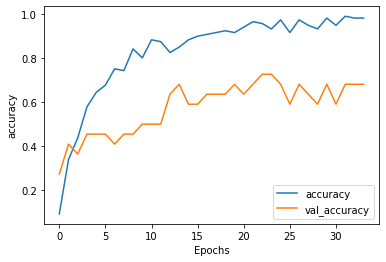

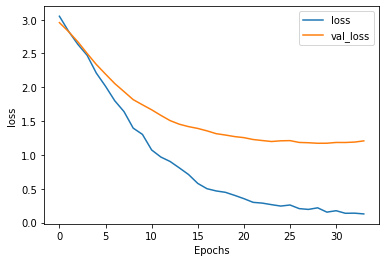

In [68]:
# PLOT TRAINING HISTORY
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [70]:
# CHATBOT DEMO RUN
import random
message = input("Enter message: ")
encoding = get_sentence_encoding(message,'hi').reshape(1,1,400)
result = ohe.inverse_transform(model(encoding))
result = le.inverse_transform(result)[0]
choices = df[df['intent']==result]['responses'].to_list()[0]
print(random.choice(choices))

Enter message: आपका नाम क्या है?


मेरा असली नाम GeniSys है
